In [25]:
def make_chevron(angle, spacing, radius):
    """
    Makes a list of 5 circles in a Chevron
    """
    cos_angle = np.cos(angle * np.pi/180)
    sin_angle = np.sin(angle * np.pi/180)
    circles = [
        [0,                   0,                   radius], # origin circle
        [spacing,             0,                   radius], # first circle to the right
        [2*spacing,           0,                   radius], # second circle to the right
        [spacing*cos_angle,   spacing*sin_angle,   radius], # first diagonal circle up
        [2*spacing*cos_angle, 2*spacing*sin_angle, radius]  # second diagonal circle
    ]
    return circles

In [26]:
make_circles(90, 10, 10)

[[0, 0, 10],
 [10, 0, 10],
 [20, 0, 10],
 [6.123233995736766e-16, 10.0, 10],
 [1.2246467991473533e-15, 20.0, 10]]

In [27]:
import numpy as np

In [28]:
make_circles(60, 10, 10)

[[0, 0, 10],
 [10, 0, 10],
 [20, 0, 10],
 [5.000000000000001, 8.660254037844386, 10],
 [10.000000000000002, 17.32050807568877, 10]]

In [29]:
import matplotlib.pyplot as plt

In [30]:
def count_overlap(x, y, circles):
    """
    Counts how many circles are overlapping at x, y
    Arguments:
        x: real number
        y: real number
        cicles: list of [x_position, y_position, radius] triplets
    
    Returns:
        count: integer, number of overlapping circles at x, 
        
    This code will be slooooooow af, but goor for learning. 
    Below is a waaay faster function# that processes multiple
    points in parallel.
    """
    count = 0 # running count of cirles overlapping x, y
    
    for (x_i, y_i, r_i) in circles: # check each cicle
        
        if (x - x_i)**2 + (y - y_i)**2 < r_i**2: 
            
            count = count + 1
            
    return count

In [31]:
C1 = make_circles(75, 10, 10)

In [32]:
C1 + [[5, 5, 10]]

[[0, 0, 10],
 [10, 0, 10],
 [20, 0, 10],
 [2.5881904510252074, 9.659258262890683, 10],
 [5.176380902050415, 19.318516525781366, 10],
 [5, 5, 10]]

In [33]:
count_overlap(0, 0, C1)

1

In [34]:
count_overlap(5, 5, C1)

3

In [35]:
def count_overlaps_fast(xy, circles):
    """
    For each xy_i in xy matrix, counts overlapping circles.
    ARGUMENTS
        xy: (num_points, 2) matrix of points
        circles: list of [x, y, r] triplets
        
    RETURNS:
        counts: (num_points) vector of integers
                showing number of overlapping
                circles at point xy_i
    """
    circles = np.array(circles) # shape (num_circles, 3)
    
    # reshape centres to (2, 1, num_circles) array
    circle_centres = circles[:, :2].reshape(1, -1, 2)
    circle_centres = np.transpose(circle_centres, (2, 0, 1))
    
    # reshape points to (2, num_points, 1) array
    xy = xy.reshape(1, -1, 2)
    xy = np.transpose(xy, (2, 1, 0))
    
    # auto broadcasts to (2, num_points, num_circles)
    SQ_dist = (xy - circle_centres)**2
    
    # summation over first axis, (num_points, num_circles)
    SQ_dist_matrix = np.sum(SQ_dist, 0)
    
    # squared radius of each circle, reshape to (1, num_circles)
    R2 = circles[:, 2]**2
    R2 = R2.reshape(1, -1)
    
    # in each column, count number of SQ_dist within radius
    counts = np.sum( SQ_dist_matrix <  R2, 1)
    
    return counts


Triple coverage area: 58.5


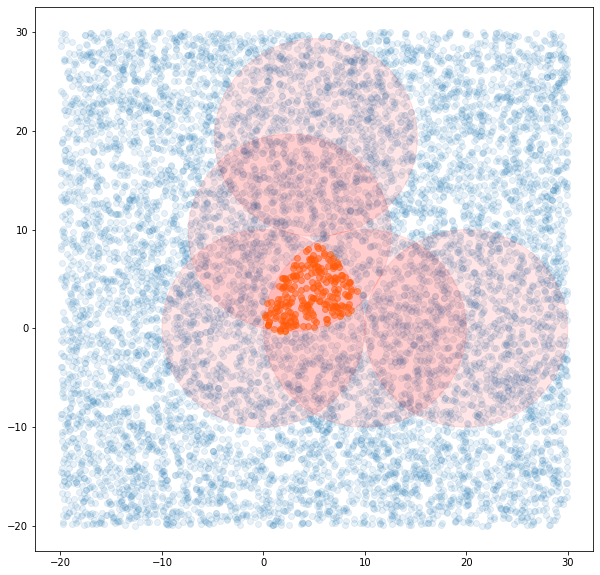

In [36]:
# make a load of points in the (-20, 30) x (-20, 30) square
xy = -20 + 50 * np.random.uniform(size=(10000, 2))
counts = count_overlaps_fast(xy, C1)

triple_coverage_area = 50 * 50 * np.mean(counts > 2)
print("Triple coverage area:", triple_coverage_area)

def plot_points_and_circles(circles):
    # plot points, circles
    fig, ax = plt.subplots(figsize=(10, 10))
    counts = count_overlaps_fast(xy, circles)
    triple_mask = counts > 2
    ax.scatter(xy[~triple_mask, 0], xy[~triple_mask, 1], alpha=0.1)
    ax.scatter(xy[triple_mask, 0], xy[triple_mask, 1], alpha=0.5)

    # add each circle to the plot
    for c in circles:
        circle_plot_object = plt.Circle(c[:2], c[2], color='r', alpha=0.1)
        ax.add_artist(circle_plot_object)

plot_points_and_circles(C1)

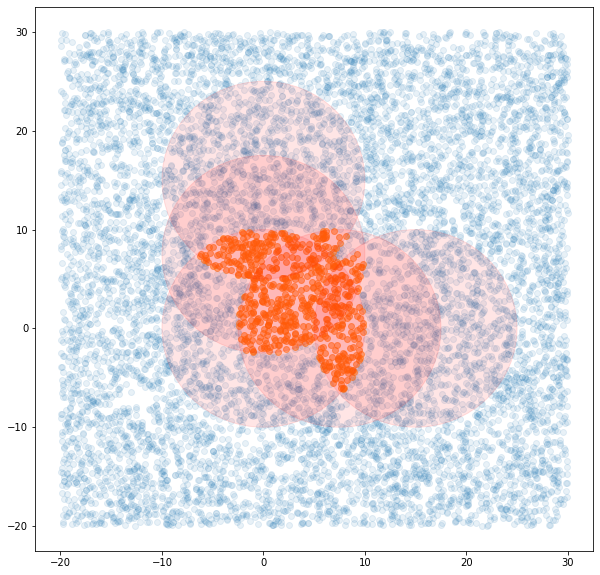

In [37]:
plot_points_and_circles(make_circles(90, 7.5, 10))

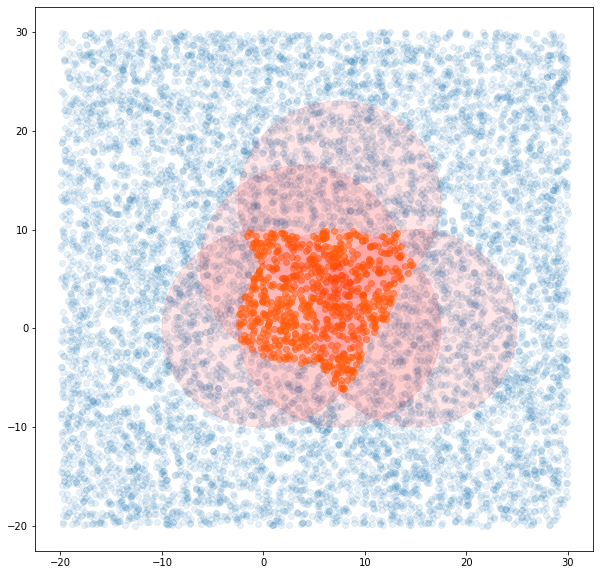

In [38]:
plot_points_and_circles(make_circles(60, 7.5, 10))

In [39]:
def check_circle_angles(xy, circles, max_angle=180):
    """
    Computes the angles from xy to each circle centre, then
    checks inter-circle angle is below max_angle
    """
    
    # not enough neighbors, type = 0
    if circles.shape[0] < 3:
        return 0
    
    circles_centres = np.array(circles[:, :2])
    
    dx = xy[0] - circles_centres[:, 0]
    dy = xy[1] - circles_centres[:, 1]
    
    # get ther angle to all neighbor centres
    angles = np.sort(np.arctan2(dx, dy))
    angles = np.hstack([angles, angles[0] + 2*np.pi])
    
    # get the angle differences
    delta_angles = np.abs(angles[1:] - angles[:-1])
    
    # largest angle separation is over limit, type = 1
    if delta_angles.max() > max_angle * np.pi / 180:
        return 1
    
    else: # largest angle is within limit, type = 2
        return 2


def check_triple_and_angles(xy, circles, max_angle=180):
    """
    Finds all xy points with 3 overlapping circles. Then filters
    those points to get ones whose circles are angularly well spaced,
    i.e. the inter-circle angles are at most max_angle.
    """
    circles = np.array(circles).reshape(-1, 3)
    
    # for each xy point, find the nearest neighbore circles
    nbrs, counts = get_neighbor_circles(xy, circles)
    
    
    # get the point type, 
    #     0: useless
    #     1: triple coverage but not surrounded
    #     2: triple coverage and surrounded
    xy_type = []
    for xy_i, nbr_i in zip(xy, nbrs):
        type_i = check_circle_angles(xy_i, circles[nbr_i, :])
        xy_type.append(type_i)
        
    xy_type = np.array(xy_type)
    
    return xy_type


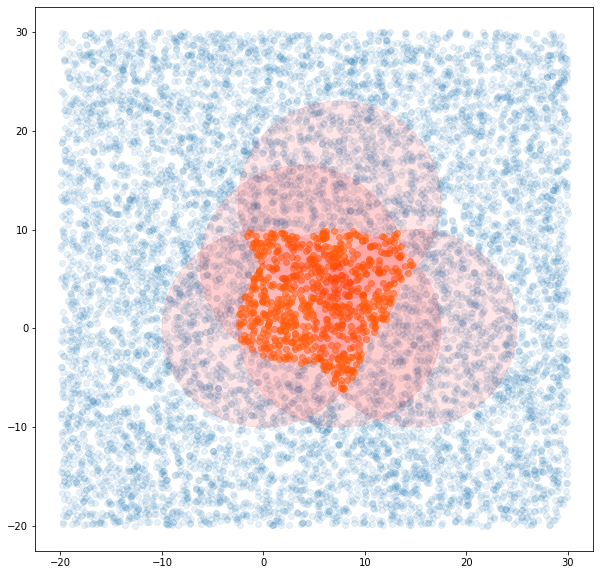

In [40]:
plot_points_and_circles(make_circles(60, 7.5, 10))

In [41]:
def plot_points_types(circles):
    # plot points, circles
    fig, ax = plt.subplots(figsize=(10, 10))
    circles = np.array(circles)
    min_x = (circles[:, 0] - circles[:, 2]).min()
    max_x = (circles[:, 0] + circles[:, 2]).max()
    min_y = (circles[:, 1] - circles[:, 2]).min()
    max_y = (circles[:, 1] + circles[:, 2]).max()
    x_points = min_x + (max_x - min_x) * np.random.uniform(size=(100000, 1))
    y_points = min_y + (max_y - min_y) * np.random.uniform(size=(100000, 1))
    xy = np.hstack([x_points, y_points])
    types = check_triple_and_angles(xy, circles)
    green_area = (np.mean(types==2))*(max_x - min_x)*(max_y-min_y)
    orange_area = (np.mean(types==1))*(max_x - min_x)*(max_y-min_y) + green_area
    ax.set_title("orange area:"+str(orange_area)+", green area:"+ str(green_area))
    ax.set_aspect("equal")
    for t in np.unique(types):
        mask = t == types
        alpha = [0.1, 0.1, 1][int(t)]
        ax.scatter(xy[mask, 0], xy[mask, 1], alpha=alpha)
        if np.sum(mask)==0: ax.scatter(0, 0, alpha=0)
    # add each circle to the plot
    for c in circles:
        circle_plot_object = plt.Circle(c[:2], c[2], color='r', alpha=0.1)
        ax.add_artist(circle_plot_object)
    
    return green_area, orange_area

        

[[7.0, 59.0, 73.35374444074812, 209.10495615644294], [7.0, 59.5, 74.36904247085275, 207.37647243081673], [7.0, 60.0, 71.73754109578748, 206.1580524030129], [7.5, 59.0, 78.20087263506542, 193.82316285167536], [7.5, 59.5, 78.41777879322404, 193.2615089112653], [7.5, 60.0, 77.07377774387093, 192.55165807592385], [8.0, 59.0, 78.35830325759713, 179.54683706468933], [8.0, 59.5, 79.63105601324546, 177.5674028925264], [8.0, 60.0, 79.27274434299257, 176.85232478733428]]


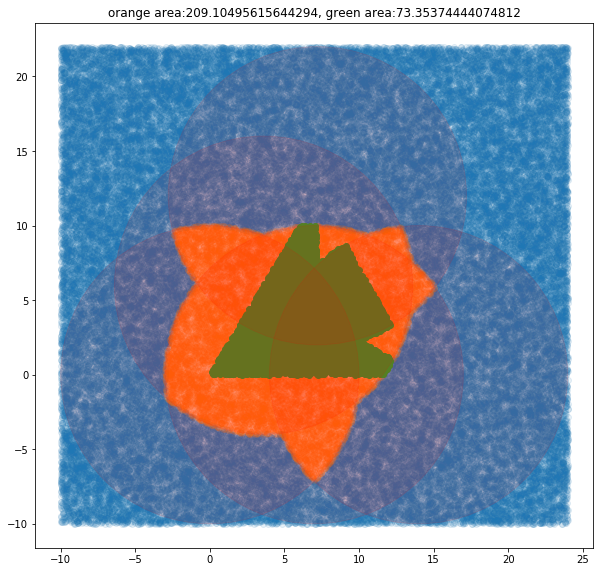

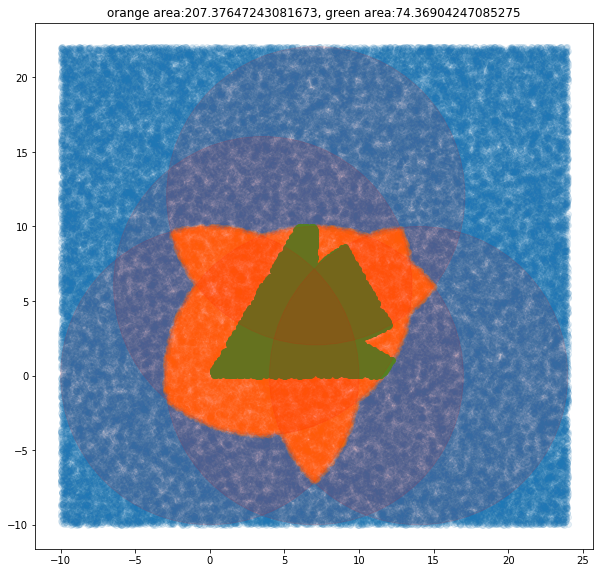

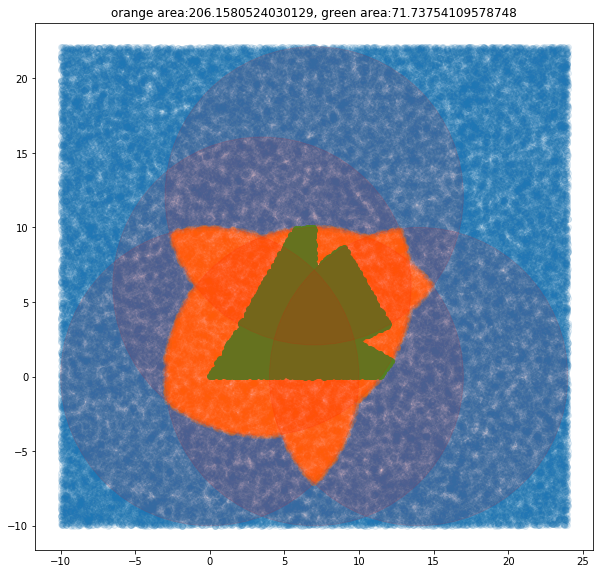

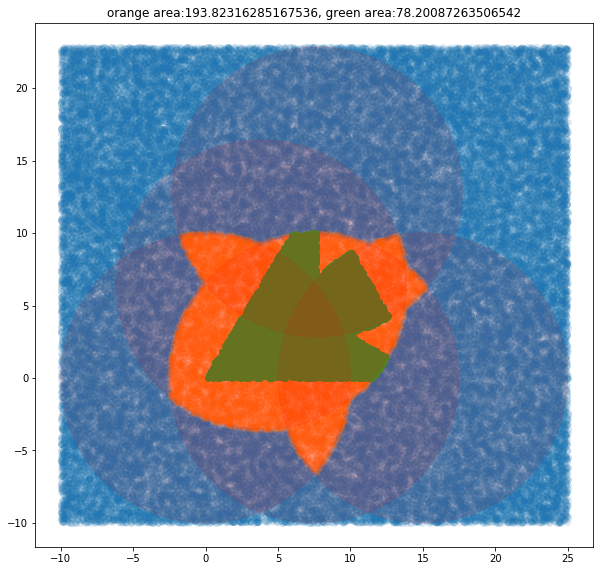

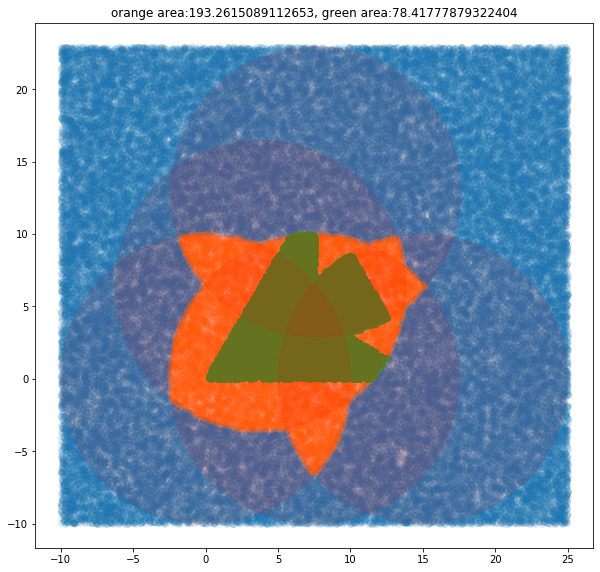

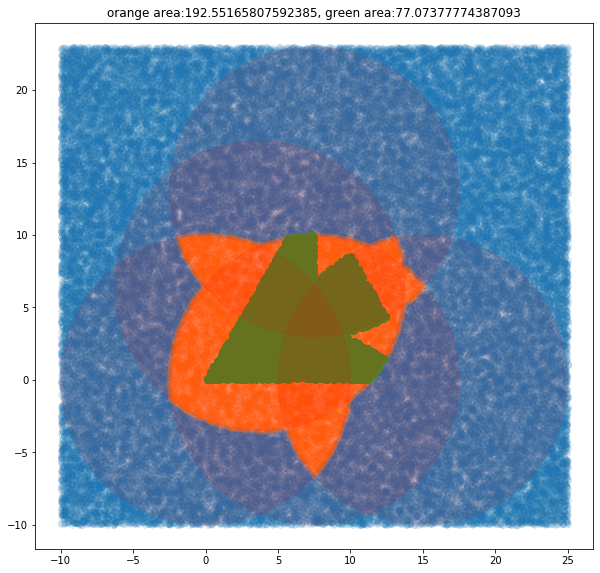

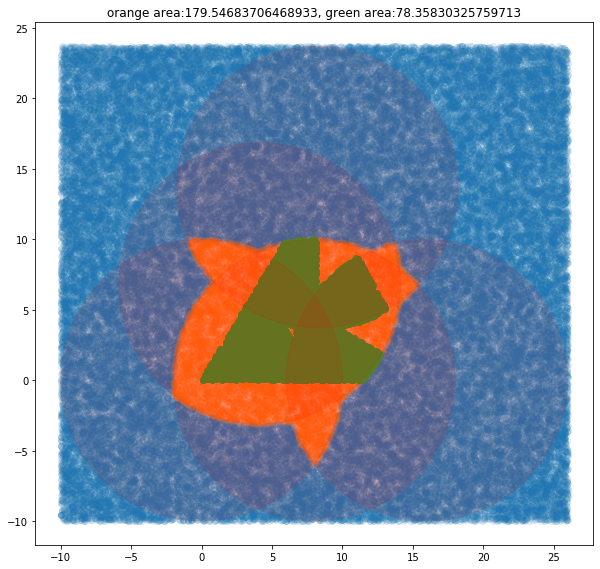

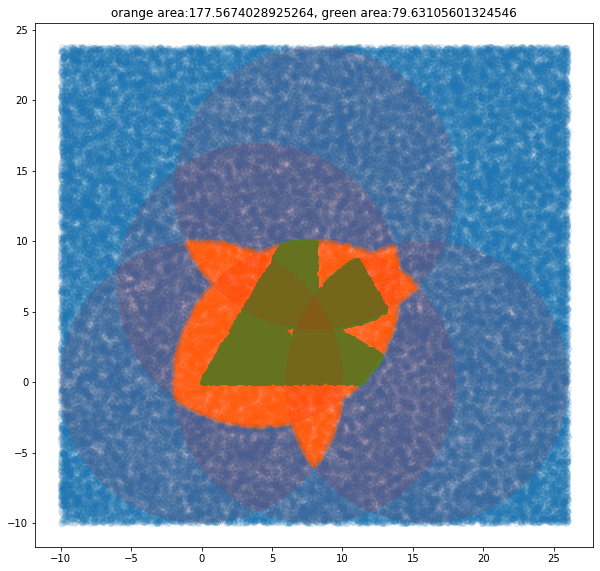

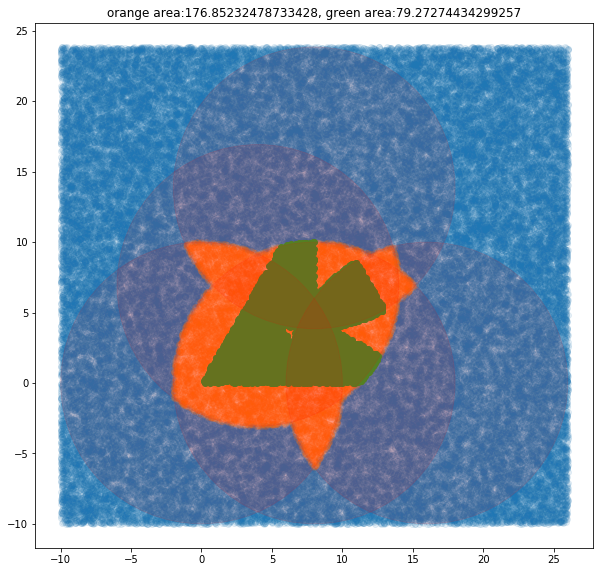

In [42]:
spacing= np.linspace(7, 8, 3)
angles= np.linspace(59, 60, 3)
areas=[]
for space in spacing:
    for angle in angles:
        area = plot_points_types(make_circles(angle, space, 10))
        area = [space, angle] + [area[0], area[1]]
        areas.append(area)
        
print(areas)




In [43]:
for res in areas:
    print (res)

[7.0, 59.0, 73.35374444074812, 209.10495615644294]
[7.0, 59.5, 74.36904247085275, 207.37647243081673]
[7.0, 60.0, 71.73754109578748, 206.1580524030129]
[7.5, 59.0, 78.20087263506542, 193.82316285167536]
[7.5, 59.5, 78.41777879322404, 193.2615089112653]
[7.5, 60.0, 77.07377774387093, 192.55165807592385]
[8.0, 59.0, 78.35830325759713, 179.54683706468933]
[8.0, 59.5, 79.63105601324546, 177.5674028925264]
[8.0, 60.0, 79.27274434299257, 176.85232478733428]


In [44]:
def get_neighbor_circles(xy, circles):
    """
    For each xy_i in xy matrix, counts overlapping circles.
    ARGUMENTS
        xy: (num_points, 2) matrix of points
        circles: list of [x, y, r] triplets
        
    RETURNS:
        counts: (num_points) vector of integers
                showing number of overlapping
                circles at point xy_i
    """
    circles = np.array(circles) # shape (num_circles, 3)
    
    # reshape centres to (2, 1, num_circles) array
    circle_centres = circles[:, :2].reshape(1, -1, 2)
    circle_centres = np.transpose(circle_centres, (2, 0, 1))
    
    # reshape points to (2, num_points, 1) array
    xy = xy.reshape(1, -1, 2)
    xy = np.transpose(xy, (2, 1, 0))
    
    # auto broadcasts to (2, num_points, num_circles)
    SQ_dist = (xy - circle_centres)**2
    
    # summation over first axis, (num_points, num_circles)
    SQ_dist_matrix = np.sum(SQ_dist, 0)
    
    # squared radius of each circle, reshape to (1, num_circles)
    R2 = circles[:, 2]**2
    
    # for each row, get the neighbour circles (if any) with distance
    ngbr_circles = [np.where(sq<R2)[0] for sq in SQ_dist_matrix]
    
    counts = np.array([len(nbrs) for nbrs in ngbr_circles])
    
    return ngbr_circles, counts


In [45]:
def Compute_Kill_Zone(circles):
    """
    Circles is a list of lists of radius x and y points. 
    The result is the orange area is the trip coverage and green is trip coverage + 60 degree crosscut.
    Make_Circles = chevron.
    """
    # plot points, circles
    circles = np.array(circles)
    min_x = (circles[:, 0] - circles[:, 2]).min()
    max_x = (circles[:, 0] + circles[:, 2]).max()
    min_y = (circles[:, 1] - circles[:, 2]).min()
    max_y = (circles[:, 1] + circles[:, 2]).max()
    x_points = min_x + (max_x - min_x) * np.random.uniform(size=(100000, 1))
    y_points = min_y + (max_y - min_y) * np.random.uniform(size=(100000, 1))
    xy = np.hstack([x_points, y_points])
    types = check_triple_and_angles(xy, circles)
    green_area = (np.mean(types==2))*(max_x - min_x)*(max_y-min_y)
    orange_area = (np.mean(types==1))*(max_x - min_x)*(max_y-min_y) + green_area
    return green_area, orange_area

        

In [46]:
def Kill_Grid(spacing, radius, nx, ny):
    """
    Creates a grid of boys of x and y in number
    """
    circles = []
    for i in range(nx):
        for j in range(ny):
            new_circle = [i*spacing, j*spacing, radius]
            circles.append(new_circle)
            
    return circles

In [47]:
Kill_Grid (1, 1, 10, 3)

[[0, 0, 1],
 [0, 1, 1],
 [0, 2, 1],
 [1, 0, 1],
 [1, 1, 1],
 [1, 2, 1],
 [2, 0, 1],
 [2, 1, 1],
 [2, 2, 1],
 [3, 0, 1],
 [3, 1, 1],
 [3, 2, 1],
 [4, 0, 1],
 [4, 1, 1],
 [4, 2, 1],
 [5, 0, 1],
 [5, 1, 1],
 [5, 2, 1],
 [6, 0, 1],
 [6, 1, 1],
 [6, 2, 1],
 [7, 0, 1],
 [7, 1, 1],
 [7, 2, 1],
 [8, 0, 1],
 [8, 1, 1],
 [8, 2, 1],
 [9, 0, 1],
 [9, 1, 1],
 [9, 2, 1]]

(7.547171424, 7.606541462)

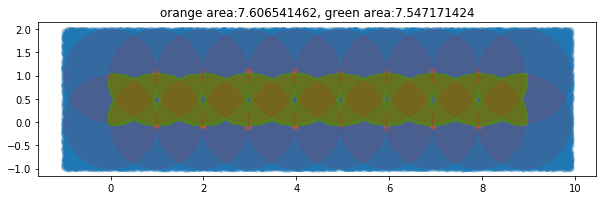

In [48]:
plot_points_types(Kill_Grid(0.99,1,10,2))

(3.2485667999999994, 3.9087635999999994)

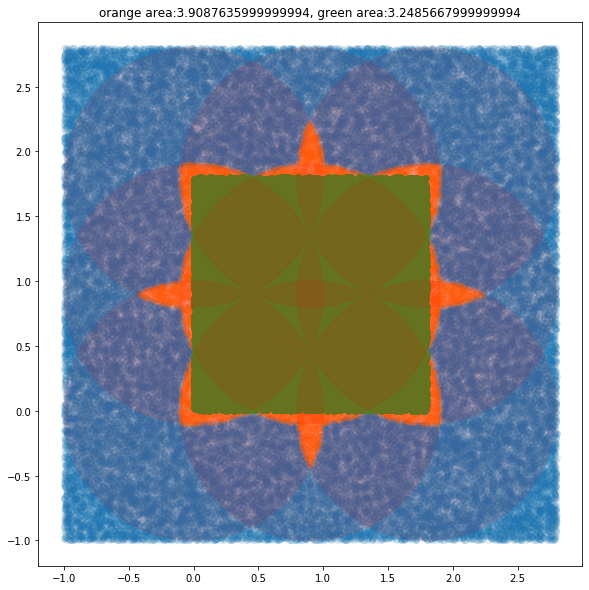

In [49]:
plot_points_types(Kill_Grid(0.9,1,3,3))

In [ ]:
spacing= np.linspace(4, 12, 9)
angles= np.linspace(30, 100, 8)
areas=[]
for space in spacing:
    for angle in angles:
        area = Compute_Kill_Zone(make_circles(angle, space, 10))
        area = [space, angle] + [area[0], area[1]]
        areas.append(area)
        
print(areas)

In [ ]:
def make_circles(angle, spacing, radius):
    """
    Makes a list of 5 circles in a bent 'L' with
    given angle and spacing between circle centres.
    """
    cos_angle = np.cos(angle * np.pi/180)
    sin_angle = np.sin(angle * np.pi/180)
    circles = [
        [0,                   0,                   radius], # origin circle
        [spacing,             0,                   radius], # first circle to the right
        [2*spacing,           0,                   radius], # second circle to the right
        [spacing*cos_angle,   spacing*sin_angle,   radius], # first diagonal circle up
        [2*spacing*cos_angle, 2*spacing*sin_angle, radius]  # second diagonal circle
    ]
    return circles